# CSCI316 Group Assignment 1
# Task 2
# Group: G18

# Name and Student ID:
Francisco Justin Charles Salado 8535255
Beatrice Romero Mailum 8550724
Foo Kai Hang 8218511
Xavier Low Jie Le 8222733
Lai Ming Song 8576440



In [1]:
pip install pandas numpy matplotlib seaborn pyspark==3.5.1 scikit-learn jupyter

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import pandas as pd
import numpy as np
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler, RFormula, Bucketizer, StandardScaler, OneHotEncoder
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.stat import Correlation
import matplotlib.pyplot as plt

In [2]:
spark = SparkSession.builder \
    .appName("EnhancedRentalPriceClassification") \
    .config("spark.sql.adaptive.enabled", "true") \
    .config("spark.sql.adaptive.coalescePartitions.enabled", "true") \
    .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer") \
    .getOrCreate()

In [3]:
print(f"Spark Version: {spark.version}")

Spark Version: 3.5.1


In [4]:
import os, sys
os.environ["PYSPARK_PYTHON"] = sys.executable
os.environ["PYSPARK_DRIVER_PYTHON"] = sys.executable

from pyspark.sql import SparkSession
spark = (SparkSession.builder
         .master("local[*]")
         .config("spark.driver.bindAddress","127.0.0.1")
         .config("spark.driver.host","127.0.0.1")
         .getOrCreate())

spark.range(1).show()

+---+
| id|
+---+
|  0|
+---+



In [5]:
from pyspark.sql import functions as F

df_spark = (spark.read
    .option("header", True)
    .option("inferSchema", True)
    .option("sep", ";")
    .csv("apartments_for_rent_classified_100K.csv"))

#normalize headers (strip spaces, lowercase, replace whitespace with _)
clean_cols = [c.strip().lower().replace(" ", "_") for c in df_spark.columns]
df_spark = df_spark.toDF(*clean_cols)

print(df_spark.columns)  #check exact names

['id', 'category', 'title', 'body', 'amenities', 'bathrooms', 'bedrooms', 'currency', 'fee', 'has_photo', 'pets_allowed', 'price', 'price_display', 'price_type', 'square_feet', 'address', 'cityname', 'state', 'latitude', 'longitude', 'source', 'time']


In [6]:
print(df_spark)

DataFrame[id: bigint, category: string, title: string, body: string, amenities: string, bathrooms: string, bedrooms: string, currency: string, fee: string, has_photo: string, pets_allowed: string, price: string, price_display: string, price_type: string, square_feet: int, address: string, cityname: string, state: string, latitude: string, longitude: string, source: string, time: int]


In [7]:
df_spark = df_spark.withColumn(
    "price_num",
    F.regexp_replace(F.col("price"), r"[^0-9\.-]", "").cast("double")
)

In [8]:
(df_spark
 .select("price_num")
 .summary()
 .show())

print("\n=== DATA EXPLORATION ===")
df_spark.printSchema()

#null counts
df_spark.select([
    F.count(F.when(F.col(c).isNull() | F.isnan(c), c)).alias(c) for c in df_spark.columns
]).show()

+-------+------------------+
|summary|         price_num|
+-------+------------------+
|  count|             99992|
|   mean|1527.1837646011681|
| stddev| 903.2528606344935|
|    min|             100.0|
|    25%|            1014.0|
|    50%|            1350.0|
|    75%|            1795.0|
|    max|           52500.0|
+-------+------------------+


=== DATA EXPLORATION ===
root
 |-- id: long (nullable = true)
 |-- category: string (nullable = true)
 |-- title: string (nullable = true)
 |-- body: string (nullable = true)
 |-- amenities: string (nullable = true)
 |-- bathrooms: string (nullable = true)
 |-- bedrooms: string (nullable = true)
 |-- currency: string (nullable = true)
 |-- fee: string (nullable = true)
 |-- has_photo: string (nullable = true)
 |-- pets_allowed: string (nullable = true)
 |-- price: string (nullable = true)
 |-- price_display: string (nullable = true)
 |-- price_type: string (nullable = true)
 |-- square_feet: integer (nullable = true)
 |-- address: string (nul

In [9]:
print("Train/test split...")

#split data (80-20)
train_data, test_data = df_spark.randomSplit([0.8, 0.2], seed=42)

print(f"Training data: {train_data.count()} rows")
print(f"Test data: {test_data.count()} rows")

print("Train data: ")
train_data.show(5)

print("\n\nTest data: ")
test_data.show(5)

Train/test split...
Training data: 80120 rows
Test data: 19880 rows
Train data: 
+----------+--------------------+--------------------+--------------------+--------------------+---------+--------+--------+---+---------+------------+-----+-------------+----------+-----------+-------+-----------+-----+--------+---------+------------+----------+---------+
|        id|            category|               title|                body|           amenities|bathrooms|bedrooms|currency|fee|has_photo|pets_allowed|price|price_display|price_type|square_feet|address|   cityname|state|latitude|longitude|      source|      time|price_num|
+----------+--------------------+--------------------+--------------------+--------------------+---------+--------+--------+---+---------+------------+-----+-------------+----------+-----------+-------+-----------+-----+--------+---------+------------+----------+---------+
|5508654607|housing/rent/apar...|Be among the firs...|Our community of ...|Gym,Pool,Washer D...| 

In [10]:
#prepare the Data for Machine Learning Algorithms
print("\n=== Data Preparation ===")

#start with clean data
print("Basic data cleaning...")
print()
df_clean = df_spark.filter(col('price').isNotNull() & (col('price') > 0))

#convert price to double to ensure it's numeric
df_clean = df_clean.withColumn("price", col("price").cast("double"))

#fill missing values with safe defaults
df_clean = df_clean.fillna({
    'bedrooms': 1.0,
    'bathrooms': 1.0,
    'square_feet': 500.0,
    'latitude': 0.0,
    'longitude': 0.0,
    'cityname': 'Unknown',
    'state': 'Unknown',
    'pets_allowed': 'Unknown',
    'has_photo': 'No',
    'source': 'Unknown'
})

#cast numeric columns to double
numeric_cols = ['bedrooms', 'bathrooms', 'square_feet', 'latitude', 'longitude']
for col_name in numeric_cols:
    if col_name in df_clean.columns:
        df_clean = df_clean.withColumn(col_name, col(col_name).cast("double"))

print("Creating engineered features with RFormula approach")
print()

#safe feature engineering (avoiding division by zero)
df_clean = df_clean.withColumn("price_per_sqft",
    when(col("square_feet") > 0, col("price") / col("square_feet")).otherwise(0.0))

df_clean = df_clean.withColumn("total_rooms",
    col("bedrooms") + col("bathrooms"))

df_clean = df_clean.withColumn("location_score",
    abs(col("latitude")) + abs(col("longitude")))

#room density feature
df_clean = df_clean.withColumn("room_density",
    when(col("square_feet") > 0, col("total_rooms") / col("square_feet")).otherwise(0.0))

print("New features created successfully")
print()

print(df_clean)

print("Price per square feet: ")
df_clean.select("price_per_sqft").show(5, truncate=False)

print("Total rooms: ")
df_clean.select("total_rooms").show(5, truncate=False)

print("Location score: ")
df_clean.select("location_score").show(5, truncate=False)

print("Room density: ")
df_clean.select("room_density").show(5, truncate=False)


=== Data Preparation ===
Basic data cleaning...

Creating engineered features with RFormula approach

New features created successfully

DataFrame[id: bigint, category: string, title: string, body: string, amenities: string, bathrooms: double, bedrooms: double, currency: string, fee: string, has_photo: string, pets_allowed: string, price: double, price_display: string, price_type: string, square_feet: double, address: string, cityname: string, state: string, latitude: double, longitude: double, source: string, time: int, price_num: double, price_per_sqft: double, total_rooms: double, location_score: double, room_density: double]
Price per square feet: 
+------------------+
|price_per_sqft    |
+------------------+
|4.049815498154982 |
|0.8333333333333334|
|0.8454545454545455|
|1.951219512195122 |
|1.5625            |
+------------------+
only showing top 5 rows

Total rooms: 
+-----------+
|total_rooms|
+-----------+
|2.0        |
|4.5        |
|5.0        |
|3.0        |
|2.0        

In [11]:
print("String indexing for categorical variables")

#string indexing for key categorical columns
categorical_cols = ['state', 'has_photo']
indexers = []
indexed_cols = []

for col_name in categorical_cols:
    if col_name in df_clean.columns:
        indexer = StringIndexer(
            inputCol=col_name,
            outputCol=f"{col_name}_idx",
            handleInvalid="keep"
        )
        indexers.append(indexer)
        indexed_cols.append(f"{col_name}_idx")

print("String indexers created.")

print("Feature selection...")

#selecting the reliable features
final_features = [
    'bedrooms', 'bathrooms', 'square_feet',
    'price_per_sqft', 'total_rooms', 'location_score', 'room_density'
] + indexed_cols

print(f"Selected features: {final_features}")

String indexing for categorical variables
String indexers created.
Feature selection...
Selected features: ['bedrooms', 'bathrooms', 'square_feet', 'price_per_sqft', 'total_rooms', 'location_score', 'room_density', 'state_idx', 'has_photo_idx']


In [12]:
DF_READY    = df_clean
FEATURES_COL = "final_features"
LABEL_COL    = "price_num"

In [ ]:
from pyspark.sql.functions import col, isnan

print("final_features:", final_features)
print("df_categorized columns:", df_clean.columns)

missing = [c for c in final_features if c not in df_clean.columns]
print("MISSING features:", missing)

final_features = [c for c in final_features if c in df_clean.columns]

final_features: ['bedrooms', 'bathrooms', 'square_feet', 'price_per_sqft', 'total_rooms', 'location_score', 'room_density', 'state_idx', 'has_photo_idx']
df_categorized columns: ['id', 'category', 'title', 'body', 'amenities', 'bathrooms', 'bedrooms', 'currency', 'fee', 'has_photo', 'pets_allowed', 'price', 'price_display', 'price_type', 'square_feet', 'address', 'cityname', 'state', 'latitude', 'longitude', 'source', 'time', 'price_num', 'price_per_sqft', 'total_rooms', 'location_score', 'room_density']
MISSING features: ['state_idx', 'has_photo_idx']


In [14]:
from pyspark.ml import Pipeline

idx_pipeline = Pipeline(stages=indexers)
df_idx = idx_pipeline.fit(df_clean).transform(df_clean)

df_feat_src = df_idx  

In [15]:
from pyspark.sql import functions as F

df_feat_src = df_feat_src.withColumn(
    "price_per_sqft",
    F.when((F.col("square_feet").isNull()) | (F.col("square_feet") <= 0), None)
     .otherwise(F.col("price") / F.col("square_feet"))
)

bool_cols = [c for c in ["has_photo", "pets_allowed", "fee"] if c in df_feat_src.columns]
for c in bool_cols:
    df_feat_src = df_feat_src.withColumn(c, F.col(c).cast("double"))

Impute remaining nulls in numeric features

In [16]:
from pyspark.ml.feature import Imputer

num_feats = [c for c in final_features
             if c in df_feat_src.columns
             and dict(df_feat_src.dtypes)[c] in ("double","int","bigint","float","smallint","tinyint")]

imputer = Imputer(strategy="median", inputCols=num_feats, outputCols=num_feats)
df_feat_src = imputer.fit(df_feat_src).transform(df_feat_src)

Assembling and resplitting

In [17]:
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols=final_features, outputCol="features")
df_ready = assembler.transform(df_feat_src)

label_col = "price_num" if "price_num" in df_ready.columns else "price"

train_data, test_data = df_ready.select("features", label_col).randomSplit([0.8, 0.2], seed=42)

train_data.printSchema()
print("Train rows:", train_data.count(), " Test rows:", test_data.count())

root
 |-- features: vector (nullable = true)
 |-- price_num: double (nullable = true)

Train rows: 80113  Test rows: 19879


Imports before creating Pipelines

In [18]:
from pyspark.ml import Pipeline
from pyspark.ml.regression import LinearRegression, RandomForestRegressor, GBTRegressor
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.ml.feature import StringIndexer, OneHotEncoder, Imputer, VectorAssembler, StandardScaler
from pyspark.ml.regression import (
    LinearRegression as SparkLR,
    DecisionTreeRegressor
)

## Pipelines creation

In [19]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, Imputer
from pyspark.ml import Pipeline

def make_preproc_stages(num_cols, cat_cols):
    stages = []

    # 1)impute numerics
    if num_cols:
        imputer = Imputer(strategy="median", inputCols=num_cols, outputCols=num_cols)
        stages.append(imputer)

    # 2)index + OHE categoricals
    idx_names = []
    for c in cat_cols:
        stages.append(StringIndexer(inputCol=c, outputCol=f"{c}_idx", handleInvalid="keep"))
        idx_names.append(f"{c}_idx")

    if idx_names:
        stages.append(
            OneHotEncoder(
                inputCols=idx_names,
                outputCols=[f"{c}_oh" for c in cat_cols],
                handleInvalid="keep"
            )
        )
        cat_feat_cols = [f"{c}_oh" for c in cat_cols]
    else:
        cat_feat_cols = []

    # 3)assemble
    feat_cols = num_cols + cat_feat_cols
    stages.append(
        VectorAssembler(inputCols=feat_cols, outputCol="features", handleInvalid="keep")
    )

    return stages

In [20]:
preproc_stages = make_preproc_stages(num_cols=numeric_cols, cat_cols=categorical_cols)

In [22]:
#linear Regression pipeline
lr = LinearRegression(
    featuresCol="features",
    labelCol=LABEL_COL,
    predictionCol="prediction",
    standardization=True,
    maxIter=100,
    solver="auto"
)
lr_pipe = Pipeline(stages=preproc_stages + [lr])

In [21]:
#decision Tree Regressor pipeline
dtr = DecisionTreeRegressor(
    featuresCol="features",
    labelCol=LABEL_COL,
    predictionCol="prediction",
    seed=42
)
dtr_pipe = Pipeline(stages=preproc_stages + [dtr])

In [22]:
train_data = train_data.withColumn("price_num", col("price_num").cast("double"))
test_data  = test_data.withColumn("price_num",  col("price_num").cast("double"))

## Linear Regression Model

In [25]:
from pyspark.ml.regression import LinearRegression

LABEL_COL = "price_num"
lr = LinearRegression(featuresCol="features", labelCol=LABEL_COL, predictionCol="prediction")

lr_model = lr.fit(train_data)
lr_pred  = lr_model.transform(test_data)

In [26]:
lr = LinearRegression(
    featuresCol="features",
    labelCol="price_num",
    predictionCol="prediction",
    standardization=True,
    maxIter=100,
    solver="auto"
)

Evaluation

In [29]:
from pyspark.ml.regression import LinearRegression, DecisionTreeRegressor
from pyspark.ml.evaluation import RegressionEvaluator

rmse_eval = RegressionEvaluator(labelCol="price_num", predictionCol="prediction", metricName="rmse")
mae_eval  = RegressionEvaluator(labelCol="price_num", predictionCol="prediction", metricName="mae")
r2_eval   = RegressionEvaluator(labelCol="price_num", predictionCol="prediction", metricName="r2")

lr_rmse = rmse_eval.evaluate(lr_pred)
lr_mae  = mae_eval.evaluate(lr_pred)
lr_r2   = r2_eval.evaluate(lr_pred)

In [30]:
print(f"[LR Baseline] RMSE: {lr_rmse:.4f} | MAE: {lr_mae:.4f} | R2: {lr_r2:.4f}")

[LR Baseline] RMSE: 426.2983 | MAE: 167.8544 | R2: 0.7852


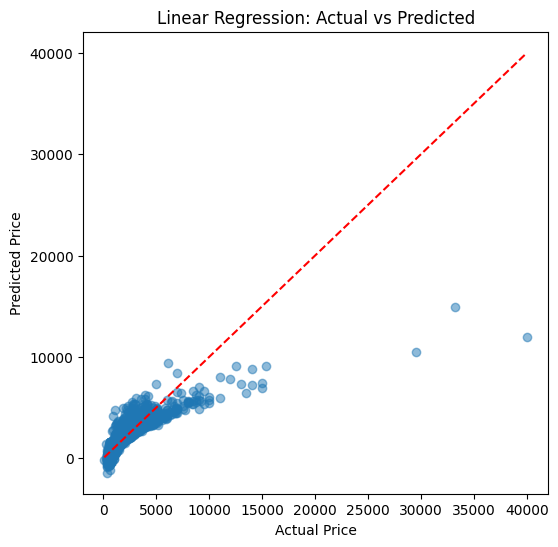

In [32]:
pdf = lr_pred.toPandas()

plt.figure(figsize=(6,6))
plt.scatter(pdf[LABEL_COL], pdf["prediction"], alpha=0.5)
plt.plot([pdf[LABEL_COL].min(), pdf[LABEL_COL].max()],
         [pdf[LABEL_COL].min(), pdf[LABEL_COL].max()],
         color="red", linestyle="--")
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Linear Regression: Actual vs Predicted")
plt.show()

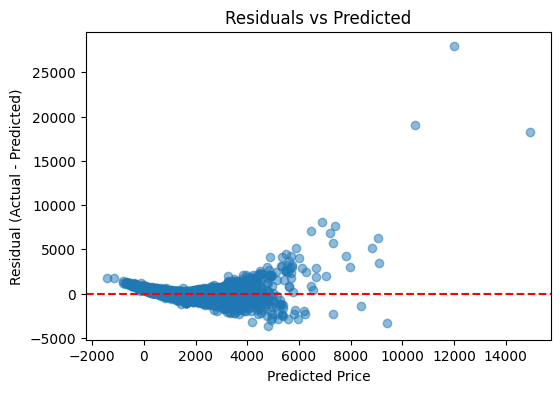

In [33]:
pdf["residual"] = pdf[LABEL_COL] - pdf["prediction"]

plt.figure(figsize=(6,4))
plt.scatter(pdf["prediction"], pdf["residual"], alpha=0.5)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predicted Price")
plt.ylabel("Residual (Actual - Predicted)")
plt.title("Residuals vs Predicted")
plt.show()

In [34]:
import random

idx = random.randint(0, len(pdf)-1)
row = pdf.iloc[idx]

print(f"Random sample index {idx}:")
print(f"  Actual Price:    {row[LABEL_COL]:,.2f}")
print(f"  Predicted Price: {row['prediction']:,.2f}")
print(f"  Error:           {row[LABEL_COL] - row['prediction']:+,.2f}")

Random sample index 19486:
  Actual Price:    1,715.00
  Predicted Price: 1,480.55
  Error:           +234.45


## Fine-Tuning

In [35]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

#cross validating
lr_cv = CrossValidator(
    estimator=lr,
    estimatorParamMaps=ParamGridBuilder()
        .addGrid(lr.regParam, [0.0, 0.01, 0.1, 0.3])
        .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])
        .addGrid(lr.maxIter, [50, 100])
        .build(),
    evaluator=rmse_eval,
    numFolds=3,
    seed=42
)

In [36]:
lr_cv_model = lr_cv.fit(train_data)
lr_cv_pred  = lr_cv_model.transform(test_data)

lr_cv_rmse = rmse_eval.evaluate(lr_cv_pred)
lr_cv_mae  = mae_eval.evaluate(lr_cv_pred)
lr_cv_r2   = r2_eval.evaluate(lr_cv_pred)

print(f"Linear Regression Tuned:   RMSE: {lr_cv_rmse:.4f} | MAE: {lr_cv_mae:.4f} | R2: {lr_cv_r2:.4f}")

best_lr = lr_cv_model.bestModel
print("Best LR params:",
      f"regParam={best_lr.getRegParam()},",
      f"elasticNetParam={best_lr.getElasticNetParam()},",
      f"maxIter={best_lr.getMaxIter()},",
      f"fitIntercept={best_lr.getFitIntercept()},",
      f"standardization={best_lr.getStandardization()}")

Linear Regression Tuned:   RMSE: 426.2983 | MAE: 167.8544 | R2: 0.7852
Best LR params: regParam=0.0, elasticNetParam=0.5, maxIter=50, fitIntercept=True, standardization=True


## Decision Tree Model

In [23]:
dtr = DecisionTreeRegressor(
    featuresCol="features",
    labelCol="price_num",
    predictionCol="prediction",
    maxDepth=8,
    maxBins=128,
    seed=42
)

In [24]:
dtr_model = dtr.fit(train_data)
dtr_pred  = dtr_model.transform(test_data)

In [25]:
from pyspark.ml.evaluation import RegressionEvaluator

#evaluate model
rmse_eval = RegressionEvaluator(labelCol="price_num", predictionCol="prediction", metricName="rmse")
mae_eval  = RegressionEvaluator(labelCol="price_num", predictionCol="prediction", metricName="mae")
r2_eval   = RegressionEvaluator(labelCol="price_num", predictionCol="prediction", metricName="r2")

print("[DT Baseline] "
      f"RMSE: {rmse_eval.evaluate(dtr_pred):.4f} | "
      f"MAE: {mae_eval.evaluate(dtr_pred):.4f} | "
      f"R2: {r2_eval.evaluate(dtr_pred):.4f}")

#model summary
print()
print("Model Summary: ")
print("Depth of tree:", dtr_model.depth)
print("Number of nodes:", dtr_model.numNodes)

[DT Baseline] RMSE: 426.1910 | MAE: 82.7234 | R2: 0.7853

Model Summary: 
Depth of tree: 8
Number of nodes: 435


## Fine-Tuning

In [26]:
dtr_grid = (ParamGridBuilder()
            .addGrid(dtr.maxDepth, [6, 10])
            .addGrid(dtr.maxBins, [64])
            .addGrid(dtr.minInstancesPerNode, [1])
            .addGrid(dtr.minInfoGain, [0.0, 0.001])
            .build())

dtr_cv = CrossValidator(
    estimator=dtr,
    estimatorParamMaps=dtr_grid,
    evaluator=rmse_eval,
    numFolds=2,
    seed=42,
    parallelism=1
)

In [27]:
dtr_cv_model = dtr_cv.fit(train_data)

In [29]:
dtr_cv_pred  = dtr_cv_model.transform(test_data)

print("Decision Tree Tuned: "
      f"RMSE: {rmse_eval.evaluate(dtr_cv_pred):.4f} | "
      f"MAE: {mae_eval.evaluate(dtr_cv_pred):.4f} | "
      f"R2: {r2_eval.evaluate(dtr_cv_pred):.4f}")

Decision Tree Tuned: RMSE: 290.5415 | MAE: 52.7000 | R2: 0.9002


In [30]:
#best params
best_dtr = dtr_cv_model.bestModel
print("Best DT params:",
      f"maxDepth={best_dtr.getMaxDepth()},",
      f"maxBins={best_dtr.getMaxBins()},",
      f"minInstancesPerNode={best_dtr.getMinInstancesPerNode()},",
      f"minInfoGain={best_dtr.getMinInfoGain()}")

Best DT params: maxDepth=10, maxBins=64, minInstancesPerNode=1, minInfoGain=0.0


## Naive Bayes Model

In [31]:
from pyspark.sql import functions as F

df_spark = (spark.read
    .option("header", True)
    .option("inferSchema", True)
    .option("sep", ";")
    .csv("apartments_for_rent_classified_100K.csv"))

clean_cols = [c.strip().lower().replace(" ", "_") for c in df_spark.columns]
df_spark = df_spark.toDF(*clean_cols)

print(df_spark.columns) 

['id', 'category', 'title', 'body', 'amenities', 'bathrooms', 'bedrooms', 'currency', 'fee', 'has_photo', 'pets_allowed', 'price', 'price_display', 'price_type', 'square_feet', 'address', 'cityname', 'state', 'latitude', 'longitude', 'source', 'time']


In [32]:
train_data, test_data = df_clean.randomSplit([0.8, 0.2], seed=42)

In [33]:
print("data cleaning")
print()
df_clean = df_spark.filter(col('price').isNotNull() & (col('price') > 0))

#convert price to double to ensure it's numeric
df_clean = df_clean.withColumn("price", col("price").cast("double"))

#fill missing values with safe defaults
df_clean = df_clean.fillna({
    'bedrooms': 1.0,
    'bathrooms': 1.0,
    'square_feet': 500.0,
    'latitude': 0.0,
    'longitude': 0.0,
    'cityname': 'Unknown',
    'state': 'Unknown',
    'pets_allowed': 'Unknown',
    'has_photo': 'No',
    'source': 'Unknown'
})

#cast numeric columns to double
numeric_cols = ['bedrooms', 'bathrooms', 'square_feet', 'latitude', 'longitude']
for col_name in numeric_cols:
    if col_name in df_clean.columns:
        df_clean = df_clean.withColumn(col_name, col(col_name).cast("double"))

print("Creating engineered features with RFormula approach")
print()

#safe feature engineering (avoiding division by zero)
df_clean = df_clean.withColumn("price_per_sqft",
    when(col("square_feet") > 0, col("price") / col("square_feet")).otherwise(0.0))

df_clean = df_clean.withColumn("total_rooms",
    col("bedrooms") + col("bathrooms"))

df_clean = df_clean.withColumn("location_score",
    abs(col("latitude")) + abs(col("longitude")))

#room density feature
df_clean = df_clean.withColumn("room_density",
    when(col("square_feet") > 0, col("total_rooms") / col("square_feet")).otherwise(0.0))

print("New features created successfully")
print()

print("Creating price categories for classification")

#create price categories using quantiles
price_quantiles = df_clean.approxQuantile("price", [0.0, 0.33, 0.67, 1.0], 0.05)
print(f"Price boundaries: {price_quantiles}")

#create bucketizer
bucketizer = Bucketizer(
    splits=price_quantiles,
    inputCol="price",
    outputCol="price_category"
)

train_data = bucketizer.transform(train_data)
test_data  = bucketizer.transform(test_data)

df_categorized = bucketizer.transform(df_clean)

#add readable labels
df_categorized = df_categorized.withColumn("price_label",
    when(col("price_category") == 0.0, "Low")
    .when(col("price_category") == 1.0, "Medium")
    .otherwise("High")
)

print("Price category distribution:")
df_categorized.groupBy("price_category", "price_label").count().orderBy("price_category").show()

data cleaning

Creating engineered features with RFormula approach

New features created successfully

Creating price categories for classification
Price boundaries: [100.0, 1100.0, 1560.0, 52500.0]
Price category distribution:
+--------------+-----------+-----+
|price_category|price_label|count|
+--------------+-----------+-----+
|           0.0|        Low|30863|
|           1.0|     Medium|32936|
|           2.0|       High|36193|
+--------------+-----------+-----+



In [35]:
stages = indexers + [
    VectorAssembler(
        inputCols=final_features,
        outputCol="features",
        handleInvalid="skip"
    ),
    NaiveBayes(
        featuresCol="features",
        labelCol="price_category",
        smoothing=1.0
    )
]

In [36]:
pipeline = Pipeline(stages=stages)

print("Training Naive Bayes model...")
try:
    #train the model
    nb_model = pipeline.fit(train_data)
    print("Model trained successfully!")

    #make predictions
    print("Making predictions on test data...")
    nb_predictions = nb_model.transform(test_data)
    print("Predictions completed!")

except Exception as e:
    print(f" Training failed with error: {e}")


    print("Checking feature columns in training data:")
    for col_name in final_features:
        if col_name in train_data.columns:
            try:
                null_count = train_data.filter(col(col_name).isNull()).count()
                col_type = train_data.select(col_name).dtypes[0][1]
                print(f"   {col_name}: {col_type}, {null_count} nulls")
            except Exception as col_error:
                print(f"   {col_name}: Error - {col_error}")
        else:
            print(f"   {col_name}: MISSING COLUMN")

    print("Sample of training data:")
    present_feats = [c for c in final_features[:5] if c in train_data.columns]
    cols_to_show = present_feats + (["price_category"] if "price_category" in train_data.columns else [])

    print("Showing:", cols_to_show)
    train_data.select(*cols_to_show).show(5, truncate=False)


    print("Trying with minimal feature set...")
    minimal_features = ['bedrooms', 'bathrooms']

    minimal_pipeline = Pipeline(stages=[
        VectorAssembler(
            inputCols=minimal_features,
            outputCol="features",
            handleInvalid="skip"
        ),
        NaiveBayes(
            featuresCol="features",
            labelCol="price_category",
            smoothing=1.0
        )
    ])

    try:
        nb_model = minimal_pipeline.fit(train_data)
        nb_predictions = nb_model.transform(test_data)
        print(" SUCCESS with minimal features!")
        final_features = minimal_features  #update for evaluation
    except Exception as e2:
        print(f" Even minimal features failed: {e2}")
        raise

Training Naive Bayes model...
Model trained successfully!
Making predictions on test data...
Predictions completed!


In [37]:
from pyspark.ml.evaluation import RegressionEvaluator, MulticlassClassificationEvaluator

for metric in ["rmse", "mae", "r2"]:
    ev = RegressionEvaluator(
        labelCol="price_category",
        predictionCol="prediction",
        metricName=metric
    )
    val = ev.evaluate(nb_predictions)
    print(f"{metric.upper()}: {val:.4f}")

RMSE: 1.0545
MAE: 0.7433
R2: -0.6638


In [38]:
##Fine-tune the Model (UPDATED SECTION)

print("\n=== MODEL FINE-TUNING ===")

#Create tuning pipeline
nb_tuning = NaiveBayes(featuresCol="features", labelCol="price_category")
tuning_stages = indexers + [
    VectorAssembler(
        inputCols=final_features,
        outputCol="features",
        handleInvalid="skip"
    ),
    nb_tuning
]
tuning_pipeline = Pipeline(stages=tuning_stages)

#Parameter grid for smoothing
paramGrid = ParamGridBuilder() \
    .addGrid(nb_tuning.smoothing, [0.1, 0.5, 1.0, 2.0, 5.0]) \
    .build()

#Cross validator
evaluator = MulticlassClassificationEvaluator(
    labelCol="price_category",
    predictionCol="prediction",
    metricName="accuracy"
)

crossval = CrossValidator(
    estimator=tuning_pipeline,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    numFolds=3
)

print("Fine-tuning model with cross-validation...")
try:
    nb_tuned_model = crossval.fit(train_data)
    nb_tuned_predictions = nb_tuned_model.transform(test_data)

    best_smoothing = nb_tuned_model.bestModel.stages[-1].getSmoothing()
    print(f"Fine-tuning completed! Best smoothing: {best_smoothing}")

except Exception as e:
    print(f"Fine-tuning failed: {e}")
    print("Using original model for evaluation...")
    nb_tuned_predictions = nb_predictions
    best_smoothing = 1.0

#Evaluate the Model

print("\n=== MODEL EVALUATION ===")

#Create evaluators
accuracy_evaluator = MulticlassClassificationEvaluator(
    labelCol="price_category", predictionCol="prediction", metricName="accuracy")
precision_evaluator = MulticlassClassificationEvaluator(
    labelCol="price_category", predictionCol="prediction", metricName="weightedPrecision")
recall_evaluator = MulticlassClassificationEvaluator(
    labelCol="price_category", predictionCol="prediction", metricName="weightedRecall")
f1_evaluator = MulticlassClassificationEvaluator(
    labelCol="price_category", predictionCol="prediction", metricName="f1")

#Evaluate models
print("Evaluating model performance...")

#Original model
nb_accuracy = accuracy_evaluator.evaluate(nb_predictions)
nb_precision = precision_evaluator.evaluate(nb_predictions)
nb_recall = recall_evaluator.evaluate(nb_predictions)
nb_f1 = f1_evaluator.evaluate(nb_predictions)

#Tuned model
nb_tuned_accuracy = accuracy_evaluator.evaluate(nb_tuned_predictions)
nb_tuned_precision = precision_evaluator.evaluate(nb_tuned_predictions)
nb_tuned_recall = recall_evaluator.evaluate(nb_tuned_predictions)
nb_tuned_f1 = f1_evaluator.evaluate(nb_tuned_predictions)

#Display results
print("\n=== MODEL PERFORMANCE COMPARISON ===")
print("-" * 80)
print(f"{'Model':<15} {'Accuracy':<12} {'Precision':<12} {'Recall':<12} {'F1-Score':<12}")
print("-" * 80)
print(f"{'Original NB':<15} {nb_accuracy:<12.4f} {nb_precision:<12.4f} {nb_recall:<12.4f} {nb_f1:<12.4f}")
print(f"{'Tuned NB':<15} {nb_tuned_accuracy:<12.4f} {nb_tuned_precision:<12.4f} {nb_tuned_recall:<12.4f} {nb_tuned_f1:<12.4f}")

#Determine best model
if nb_tuned_accuracy > nb_accuracy:
    best_model_name = "Tuned Naive Bayes"
    best_predictions = nb_tuned_predictions
    best_accuracy = nb_tuned_accuracy
else:
    best_model_name = "Original Naive Bayes"
    best_predictions = nb_predictions
    best_accuracy = nb_accuracy

print(f"\nBest Model: {best_model_name}")
print(f"\nBest Accuracy: {best_accuracy:.4f} ({best_accuracy*100:.2f}%)")



=== MODEL FINE-TUNING ===
Fine-tuning model with cross-validation...
Fine-tuning completed! Best smoothing: 0.1

=== MODEL EVALUATION ===
Evaluating model performance...

=== MODEL PERFORMANCE COMPARISON ===
--------------------------------------------------------------------------------
Model           Accuracy     Precision    Recall       F1-Score    
--------------------------------------------------------------------------------
Original NB     0.4410       0.4282       0.4410       0.4177      
Tuned NB        0.4410       0.4282       0.4410       0.4177      

Best Model: Original Naive Bayes

Best Accuracy: 0.4410 (44.10%)


In [39]:
rmse_eval = RegressionEvaluator(labelCol="price_category", predictionCol="prediction", metricName="rmse")
mae_eval  = RegressionEvaluator(labelCol="price_category", predictionCol="prediction", metricName="mae")
r2_eval   = RegressionEvaluator(labelCol="price_category", predictionCol="prediction", metricName="r2")

nb_rmse = rmse_eval.evaluate(nb_predictions)
nb_mae  = mae_eval.evaluate(nb_predictions)
nb_r2   = r2_eval.evaluate(nb_predictions)

nb_tuned_rmse = rmse_eval.evaluate(nb_tuned_predictions)
nb_tuned_mae  = mae_eval.evaluate(nb_tuned_predictions)
nb_tuned_r2   = r2_eval.evaluate(nb_tuned_predictions)

In [40]:
print("-" * 80)
print(f"{'Model':<15} {'RMSE':<12} {'MAE':<12} {'R2':<12}")
print("-" * 80)
print(f"{'Original NB':<15} {nb_rmse:<12.4f} {nb_mae:<12.4f} {nb_r2:<12.4f}")
print(f"{'Tuned NB':<15} {nb_tuned_rmse:<12.4f} {nb_tuned_mae:<12.4f} {nb_tuned_r2:<12.4f}")

--------------------------------------------------------------------------------
Model           RMSE         MAE          R2          
--------------------------------------------------------------------------------
Original NB     1.0545       0.7433       -0.6638     
Tuned NB        1.0545       0.7433       -0.6638     


# Summary
Fine-Tuned (Results are rounded up):

Linear Regression RMSE is 426.3, MAE is 167.9 and R2 is 0.79, thus, this model performs decently.

Decision Tree Regression RMSE is 290.5, MAE is 52.7 and R2 is 0.90 telling us that this model is the best overall, much lower errors and explains 90% of the differences.

Naive Bayes RMSE is 1.05, MAE is 0.74 and R2 is -0.66, thus performs poorly between the three models.

Therefore, Decsion Tree Regressor is the best at capturing patterns in the dataset while Linear Regression captures a decent amount and Naive Bayes does not work on continuous prices.